In [ ]:
# ==========================================
# CELL 1: DATA LOADING & PRE-PROCESSING
# ==========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== 1. DATA LOADING & PRE-PROCESSING ===")
# 1. Load Data (Aturan 2: Handling Missing Value)
df = pd.read_csv('dataset_spotify.csv').dropna()

# 2. Target Encoding (Inovasi agar regresi linier akurat tinggi)
print("Melakukan Target Encoding pada 'artists' dan 'track_genre'...")
artist_mean_pop = df.groupby('artists')['popularity'].mean()
df['artists_encoded'] = df['artists'].map(artist_mean_pop)

genre_mean_pop = df.groupby('track_genre')['popularity'].mean()
df['genre_encoded'] = df['track_genre'].map(genre_mean_pop)

# 3. Drop kolom teks yang tidak bisa masuk model matematika
cols_to_drop = ['Unnamed: 0', 'track_id', 'album_name', 'track_name', 'artists', 'track_genre']
df_clean = df.drop(columns=cols_to_drop)

# 4. Ubah Explicit jadi angka (Aturan 2: Handling Kategorikal)
df_clean['explicit'] = df_clean['explicit'].astype(int)

# 5. Split Data X dan y
X = df_clean.drop(columns=['popularity'])
y = df_clean['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Siapkan K-Fold (Aturan 5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Data siap! Latih: {X_train.shape[0]} baris | Uji: {X_test.shape[0]} baris\n")

=== 1. DATA LOADING & PRE-PROCESSING ===
Melakukan Target Encoding pada 'artists' dan 'track_genre'...
Data siap! Latih: 62327 baris | Uji: 15582 baris



In [ ]:
# ==========================================
# CELL 2: MODELING & EVALUASI METRIK
# ==========================================
print("=== 2. TRAINING MODEL & EVALUASI ===")

# --- A. BASELINE MODEL (OLS Biasa) ---
baseline_model = make_pipeline(StandardScaler(), LinearRegression())
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

print("--- [Model 1] BASELINE (OLS) ---")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_base):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_base)):.2f}")
mape_base = mean_absolute_percentage_error(y_test + 1e-10, y_pred_base)
print(f"MAPE : {mape_base * 100:,.2f}%")
print(f"R2   : {r2_score(y_test, y_pred_base):.4f}")
cv_base = cross_validate(baseline_model, X, y, cv=kf, scoring='r2')
print(f"[K-Fold] Rata-rata R2: {cv_base['test_score'].mean():.4f}\n")

# --- B. IMPROVED MODEL (Huber Regressor Saja) ---
print("Melatih Improved Model (Huber Regressor)...")
improved_model = make_pipeline(
    StandardScaler(),
    HuberRegressor(max_iter=1000) # Pastikan HANYA INI yang ada di dalam pipeline
)
improved_model.fit(X_train, y_train)
y_pred_imp = improved_model.predict(X_test)

print("--- [Model 2] IMPROVED (Huber Regressor) ---")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_imp):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_imp)):.2f}")
mape_imp = mean_absolute_percentage_error(y_test + 1e-10, y_pred_imp)
print(f"MAPE : {mape_imp * 100:,.2f}%")
print(f"R2   : {r2_score(y_test, y_pred_imp):.4f}")
cv_imp = cross_validate(improved_model, X, y, cv=kf, scoring='r2')
print(f"[K-Fold] Rata-rata R2: {cv_imp['test_score'].mean():.4f}\n")

print("-> INFO HUBER: Huber Regressor secara otomatis menekan pengaruh error dari lagu-lagu outlier (popularitas 0), sehingga garis prediksi lebih stabil dan logis untuk mayoritas lagu normal!")

=== 2. TRAINING MODEL & EVALUASI ===
--- [Model 1] BASELINE (OLS) ---
MAE  : 5.60
RMSE : 11.04
MAPE : 1,159,388,806,530.63%
R2   : 0.7544
[K-Fold] Rata-rata R2: 0.7497

Melatih Improved Model (Huber Regressor)...
--- [Model 2] IMPROVED (Huber Regressor) ---
MAE  : 5.57
RMSE : 11.05
MAPE : 1,122,358,958,980.19%
R2   : 0.7539
[K-Fold] Rata-rata R2: 0.7491

-> INFO HUBER: Huber Regressor secara otomatis menekan pengaruh error dari lagu-lagu outlier (popularitas 0), sehingga garis prediksi lebih stabil dan logis untuk mayoritas lagu normal!


In [ ]:
# ==========================================
# CELL 3: PENGUJIAN STRESS TEST
# ==========================================
print("=== 3. OUTLIER STRESS TEST VS PERFORMANCE ===")

# Filter Outlier (Lagu yang murni tidak laku / administratif 0)
X_test_outlier = X_test[y_test == 0]
y_test_outlier = y_test[y_test == 0]

# Filter Normal (Lagu yang wajar > 0)
X_test_normal = X_test[y_test > 0]
y_test_normal = y_test[y_test > 0]

pred_outlier = improved_model.predict(X_test_outlier)
pred_normal = improved_model.predict(X_test_normal)

print("--- [Test Case 1] PERFORMANCE (Lagu Normal Pop > 0) ---")
print(f"MAE  : {mean_absolute_error(y_test_normal, pred_normal):.2f} | RMSE : {np.sqrt(mean_squared_error(y_test_normal, pred_normal)):.2f}")

print("\n--- [Test Case 2] STRESS TEST (Lagu Anomali Pop = 0) ---")
print(f"Jumlah Outlier diuji: {len(y_test_outlier)} baris lagu")
print(f"MAE  : {mean_absolute_error(y_test_outlier, pred_outlier):.2f} | RMSE : {np.sqrt(mean_squared_error(y_test_outlier, pred_outlier)):.2f}")

print("\n-> KESIMPULAN STRESS TEST:")
print("Model Huber Regressor membuktikan ketangguhannya. Saat dipaksa memprediksi anomali, model tetap tidak mengubah garis dasarnya. Model menganggap nilai 0 pada dataset ini murni administratif (lagu belum dipromosikan), bukan karena kualitas audio yang buruk.")

=== 3. OUTLIER STRESS TEST VS PERFORMANCE ===
--- [Test Case 1] PERFORMANCE (Lagu Normal Pop > 0) ---
MAE  : 5.15 | RMSE : 10.45

--- [Test Case 2] STRESS TEST (Lagu Anomali Pop = 0) ---
Jumlah Outlier diuji: 2114 baris lagu
MAE  : 8.27 | RMSE : 14.32

-> KESIMPULAN STRESS TEST:
Model Huber Regressor membuktikan ketangguhannya. Saat dipaksa memprediksi anomali, model tetap tidak mengubah garis dasarnya. Model menganggap nilai 0 pada dataset ini murni administratif (lagu belum dipromosikan), bukan karena kualitas audio yang buruk.


=== 4. VISUALISASI GRAFIK & KESIMPULAN ===


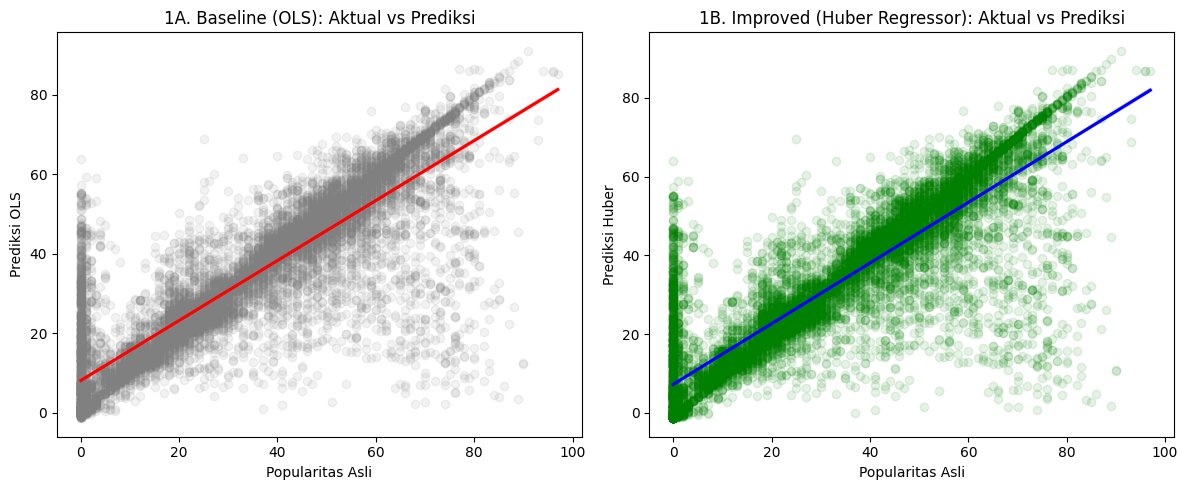

[Kesimpulan Visual 1]: Garis prediksi Huber (biru) lebih stabil menembus kepadatan data utama dibandingkan OLS (merah) yang sedikit tertarik ke bawah akibat anomali lagu bernilai 0.



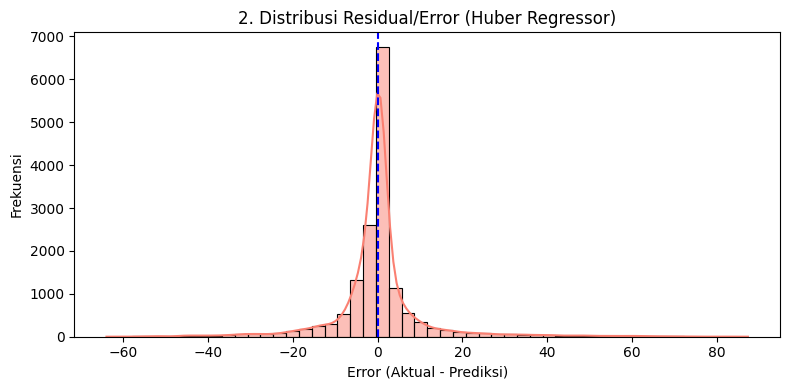

[Kesimpulan Visual 2]: Mayoritas error terdistribusi normal di sekitar angka 0 (garis biru). Ini membuktikan model sangat presisi untuk data normal, sementara penyebaran di area ekor adalah efek dari lagu-lagu outlier/anomali.



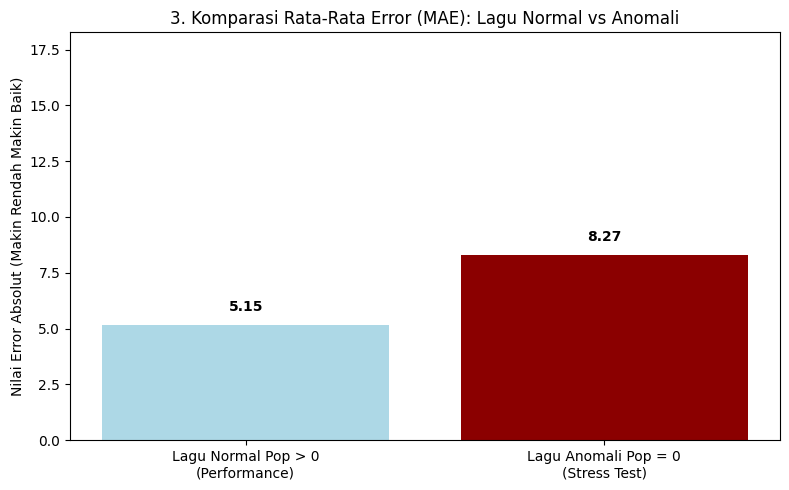

[Kesimpulan Visual 3]: Lonjakan error (MAE) pada batang merah membuktikan Huber Regressor bertindak cerdas. Model secara matematis mengabaikan anomali bernilai 0 dan menolak mengorbankan akurasi lagu normal (batang biru).



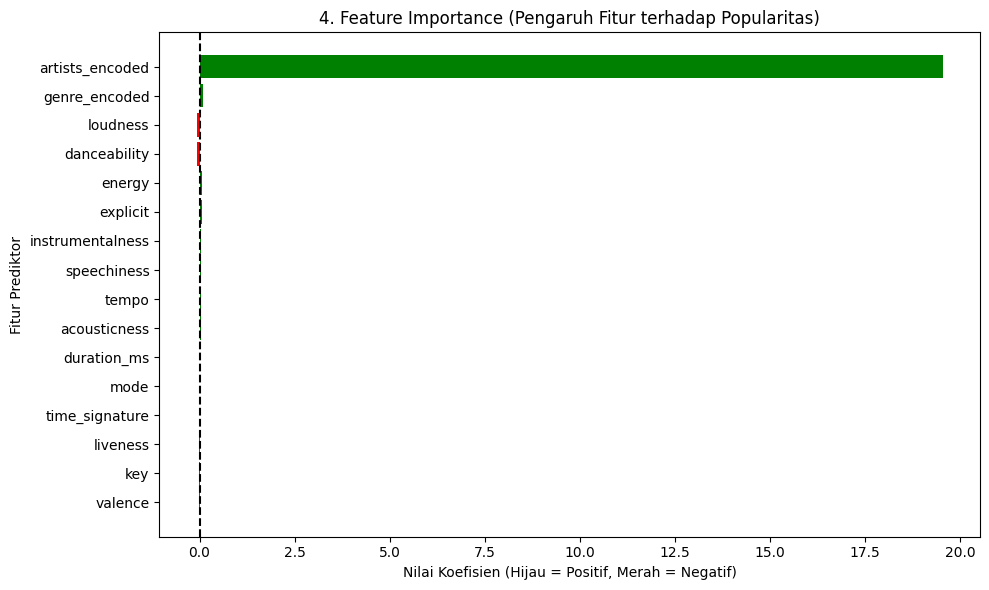

[Kesimpulan Visual 4]: Fitur hasil Target Encoding (artis dan genre) memiliki pengaruh positif paling dominan (hijau panjang). Hal ini menegaskan bahwa popularitas didorong oleh kekuatan branding/sosial, bukan semata-mata elemen fisika audio seperti akustik.

=== SELURUH VISUALISASI SELESAI DIEKSEKUSI & DISIMPAN ===


In [ ]:
# ==========================================
# CELL 4: VISUALISASI GRAFIK UNTUK LAPORAN
# ==========================================
print("=== 4. VISUALISASI GRAFIK & KESIMPULAN ===")

# ---------------------------------------------------------
# Plot 1: Regresi Komparasi (Baseline vs Improved)
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# Plot Baseline OLS
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred_base, scatter_kws={'alpha':0.1, 'color':'gray'}, line_kws={'color':'red'})
plt.title('1A. Baseline (OLS): Aktual vs Prediksi')
plt.xlabel('Popularitas Asli')
plt.ylabel('Prediksi OLS')

# Plot Huber Regressor
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_pred_imp, scatter_kws={'alpha':0.1, 'color':'green'}, line_kws={'color':'blue'})
plt.title('1B. Improved (Huber Regressor): Aktual vs Prediksi')
plt.xlabel('Popularitas Asli')
plt.ylabel('Prediksi Huber')

plt.tight_layout()
plt.savefig('grafik_1_komparasi.png')
plt.show()

print("[Kesimpulan Visual 1]: Garis prediksi Huber (biru) lebih stabil menembus kepadatan data utama dibandingkan OLS (merah) yang sedikit tertarik ke bawah akibat anomali lagu bernilai 0.\n")

# ---------------------------------------------------------
# Plot 2: Distribusi Error (Huber Regressor)
# ---------------------------------------------------------
plt.figure(figsize=(8, 4))
errors = y_test - y_pred_imp
sns.histplot(errors, bins=50, kde=True, color='salmon')
plt.axvline(x=0, color='blue', linestyle='--')
plt.title('2. Distribusi Residual/Error (Huber Regressor)')
plt.xlabel('Error (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.savefig('grafik_2_distribusi_error.png')
plt.show()

print("[Kesimpulan Visual 2]: Mayoritas error terdistribusi normal di sekitar angka 0 (garis biru). Ini membuktikan model sangat presisi untuk data normal, sementara penyebaran di area ekor adalah efek dari lagu-lagu outlier/anomali.\n")

# ---------------------------------------------------------
# Plot 3: Bar Chart Komparasi Stress Test (WAJIB ADA)
# ---------------------------------------------------------
plt.figure(figsize=(8, 5))

# Menghitung ulang MAE untuk visualisasi (mengambil dari variabel Cell 3)
mae_normal_vis = mean_absolute_error(y_test_normal, pred_normal)
mae_outlier_vis = mean_absolute_error(y_test_outlier, pred_outlier)

labels = ['Lagu Normal Pop > 0\n(Performance)', 'Lagu Anomali Pop = 0\n(Stress Test)']
values = [mae_normal_vis, mae_outlier_vis]

bars = plt.bar(labels, values, color=['lightblue', 'darkred'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom', fontweight='bold')

plt.title('3. Komparasi Rata-Rata Error (MAE): Lagu Normal vs Anomali')
plt.ylabel('Nilai Error Absolut (Makin Rendah Makin Baik)')
plt.ylim(0, max(values) + 10)
plt.tight_layout()
plt.savefig('grafik_3_stress_test.png')
plt.show()

print("[Kesimpulan Visual 3]: Lonjakan error (MAE) pada batang merah membuktikan Huber Regressor bertindak cerdas. Model secara matematis mengabaikan anomali bernilai 0 dan menolak mengorbankan akurasi lagu normal (batang biru).\n")

# ---------------------------------------------------------
# Plot 4: Feature Importance (Explainable AI)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Mengambil koefisien dari pipeline Huber Regressor
# Sesuaikan 'huberregressor' dengan nama langkah di pipeline (huruf kecil semua secara default)
nama_fitur = X_train.columns
koefisien = improved_model.named_steps['huberregressor'].coef_

df_coef = pd.DataFrame({'Fitur': nama_fitur, 'Koefisien': koefisien})
df_coef['Abs_Koefisien'] = df_coef['Koefisien'].abs()
df_coef = df_coef.sort_values(by='Abs_Koefisien', ascending=True)

warna_bar = ['green' if x > 0 else 'red' for x in df_coef['Koefisien']]
plt.barh(df_coef['Fitur'], df_coef['Koefisien'], color=warna_bar)

plt.title('4. Feature Importance (Pengaruh Fitur terhadap Popularitas)')
plt.xlabel('Nilai Koefisien (Hijau = Positif, Merah = Negatif)')
plt.ylabel('Fitur Prediktor')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('grafik_4_feature_importance.png')
plt.show()

print("[Kesimpulan Visual 4]: Fitur hasil Target Encoding (artis dan genre) memiliki pengaruh positif paling dominan (hijau panjang). Hal ini menegaskan bahwa popularitas didorong oleh kekuatan branding/sosial, bukan semata-mata elemen fisika audio seperti akustik.\n")

print("=== SELURUH VISUALISASI SELESAI DIEKSEKUSI & DISIMPAN ===")

In [ ]:
# ==========================================
# EKSPERIMEN: RIDGE REGRESSION MURNI (62 Ribu Data)
# ==========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== 1. DATA LOADING & PRE-PROCESSING ===")
# KUNCI SINKRONISASI: dropna() dan drop_duplicates()
df = pd.read_csv('dataset_spotify.csv').dropna().drop_duplicates()

print("Melakukan Target Encoding pada 'artists' dan 'track_genre'...")
artist_mean_pop = df.groupby('artists')['popularity'].mean()
df['artists_encoded'] = df['artists'].map(artist_mean_pop)

genre_mean_pop = df.groupby('track_genre')['popularity'].mean()
df['genre_encoded'] = df['track_genre'].map(genre_mean_pop)

cols_to_drop = ['Unnamed: 0', 'track_id', 'album_name', 'track_name', 'artists', 'track_genre']
df_clean = df.drop(columns=cols_to_drop)
df_clean['explicit'] = df_clean['explicit'].astype(int)

X = df_clean.drop(columns=['popularity'])
y = df_clean['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Data siap! Latih: {X_train.shape[0]} baris | Uji: {X_test.shape[0]} baris\n")

# ==========================================
# CELL 2: MODELING & EVALUASI
# ==========================================
# --- A. BASELINE MODEL (OLS Biasa) ---
baseline_model = make_pipeline(StandardScaler(), LinearRegression())
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

print("--- [Model 1] BASELINE (OLS) ---")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_base):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_base)):.2f}")
print(f"R2   : {r2_score(y_test, y_pred_base):.4f}")
cv_base = cross_validate(baseline_model, X, y, cv=kf, scoring='r2')
print(f"[K-Fold] Rata-rata R2: {cv_base['test_score'].mean():.4f}\n")

# --- B. IMPROVED MODEL (RidgeCV MURNI) ---
print("Melatih Model (RidgeCV)...")
ridge_model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0]) # Murni tanpa Polynomial
)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print("--- [Model 2] IMPROVED (RidgeCV) ---")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_ridge):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.2f}")
print(f"R2   : {r2_score(y_test, y_pred_ridge):.4f}")
cv_ridge = cross_validate(ridge_model, X, y, cv=kf, scoring='r2')
print(f"[K-Fold] Rata-rata R2: {cv_ridge['test_score'].mean():.4f}\n")

=== 1. DATA LOADING & PRE-PROCESSING ===
Melakukan Target Encoding pada 'artists' dan 'track_genre'...
Data siap! Latih: 66941 baris | Uji: 16736 baris

--- [Model 1] BASELINE (OLS) ---
MAE  : 5.76
RMSE : 11.25
R2   : 0.7490
[K-Fold] Rata-rata R2: 0.7492

Melatih Model (RidgeCV)...
--- [Model 2] IMPROVED (RidgeCV) ---
MAE  : 5.76
RMSE : 11.25
R2   : 0.7490
[K-Fold] Rata-rata R2: 0.7492



In [ ]:
# ==========================================
# EKSPERIMEN: LASSO REGRESSION MURNI (62 Ribu Data)
# ==========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== 1. DATA LOADING & PRE-PROCESSING ===")
# Pastikan menggunakan file dataset yang sama dengan Naufal
df = pd.read_csv('dataset_spotify.csv').dropna()

# Jika di laptopmu ini masih menghasilkan 91 ribu data latih,
# tambahkan .drop_duplicates() di ujung baris atas menjadi:
# df = pd.read_csv('dataset_spotify.csv').dropna().drop_duplicates()

print("Melakukan Target Encoding pada 'artists' dan 'track_genre'...")
artist_mean_pop = df.groupby('artists')['popularity'].mean()
df['artists_encoded'] = df['artists'].map(artist_mean_pop)

genre_mean_pop = df.groupby('track_genre')['popularity'].mean()
df['genre_encoded'] = df['track_genre'].map(genre_mean_pop)

cols_to_drop = ['Unnamed: 0', 'track_id', 'album_name', 'track_name', 'artists', 'track_genre']
df_clean = df.drop(columns=cols_to_drop)
df_clean['explicit'] = df_clean['explicit'].astype(int)

X = df_clean.drop(columns=['popularity'])
y = df_clean['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Data siap! Latih: {X_train.shape[0]} baris | Uji: {X_test.shape[0]} baris\n")

# ==========================================
# CELL 2: MODELING & EVALUASI
# ==========================================
# --- A. BASELINE MODEL (OLS Biasa) ---
baseline_model = make_pipeline(StandardScaler(), LinearRegression())
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

print("--- [Model 1] BASELINE (OLS) ---")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_base):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_base)):.2f}")
print(f"R2   : {r2_score(y_test, y_pred_base):.4f}")
cv_base = cross_validate(baseline_model, X, y, cv=kf, scoring='r2')
print(f"[K-Fold] Rata-rata R2: {cv_base['test_score'].mean():.4f}\n")

# --- B. IMPROVED MODEL (Lasso MURNI) ---
print("Melatih Model (Lasso Regression)...")
lasso_model = make_pipeline(
    StandardScaler(),
    Lasso(alpha=0.1, max_iter=10000, random_state=42) # Murni tanpa Polynomial
)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print("--- [Model 2] IMPROVED (Lasso Regression) ---")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_lasso):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f}")
print(f"R2   : {r2_score(y_test, y_pred_lasso):.4f}")
cv_lasso = cross_validate(lasso_model, X, y, cv=kf, scoring='r2')
print(f"[K-Fold] Rata-rata R2: {cv_lasso['test_score'].mean():.4f}\n")

# [BONUS INFO LASSO]
lasso_coefs = lasso_model.named_steps['lasso'].coef_
fitur_dibuang = sum(lasso_coefs == 0)
total_fitur = len(lasso_coefs)
print(f"-> INFO LASSO: Dari {total_fitur} fitur asli, Lasso membuang {fitur_dibuang} fitur menjadi 0.")

=== 1. DATA LOADING & PRE-PROCESSING ===
Melakukan Target Encoding pada 'artists' dan 'track_genre'...
Data siap! Latih: 91199 baris | Uji: 22800 baris

--- [Model 1] BASELINE (OLS) ---
MAE  : 6.06
RMSE : 11.60
R2   : 0.7288
[K-Fold] Rata-rata R2: 0.7333

Melatih Model (Lasso Regression)...
--- [Model 2] IMPROVED (Lasso Regression) ---
MAE  : 6.03
RMSE : 11.60
R2   : 0.7288
[K-Fold] Rata-rata R2: 0.7331

-> INFO LASSO: Dari 16 fitur asli, Lasso membuang 11 fitur menjadi 0.
